In [1]:
dir = r'C:\Program Files\mingw-w64\x86_64-7.2.0-posix-seh-rt_v5-rev1\mingw64\bin'
import os
os.environ['PATH'].count(dir)
os.environ['PATH'].find(dir)
os.environ['PATH'] = dir + ';' + os.environ['PATH']
import xgboost as xgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from haversine import haversine
import datetime as dt

In [2]:
'''Step1: Load Data'''
trainDF = pd.read_csv('data/train.csv', nrows=50000)
testDF = pd.read_csv('data/test.csv')
print('Size of the training set is: {} rows and {} columns'.format(*trainDF.shape))
print ("\n", list(trainDF))


Size of the training set is: 50000 rows and 11 columns

 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']


In [3]:
'''Step2: Understand Data'''
df = trainDF.describe()
print (df)

print("Train shape : ", trainDF.shape)
print("Test shape : ", testDF.shape)

dtypeDF=trainDF.dtypes.reset_index()# reset_index(): When we reset the index, the old index is added as a column, and a new sequential index is usedWhen we reset the index, the old index is added as a column, and a new sequential index is used
dtypeDF.columns=["Count","Column Type"]
dtypeDF.groupby("Column Type").aggregate('count')
print(dtypeDF)

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  50000.000000     50000.000000      50000.000000     50000.000000   
mean       1.529440         1.667260        -73.973477        40.751211   
std        0.499138         1.316442          0.037974         0.027994   
min        1.000000         1.000000        -74.393555        40.449749   
25%        1.000000         1.000000        -73.991760        40.737579   
50%        2.000000         1.000000        -73.981644        40.754425   
75%        2.000000         2.000000        -73.967079        40.768513   
max        2.000000         6.000000        -73.518051        41.091171   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       50000.000000      50000.000000   50000.000000  
mean          -73.973374         40.752025     949.708280  
std             0.036672          0.032536    3175.391374  
min           -74.398514         40.444698       1.000000  
25%           -73.991348

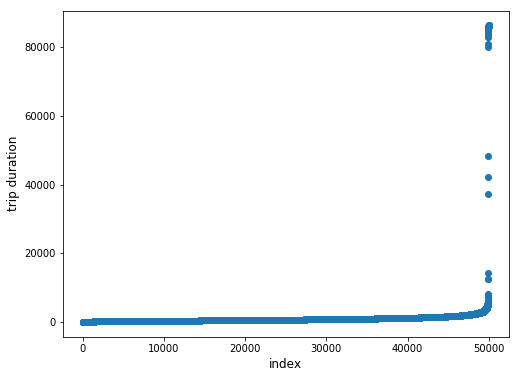

In [4]:
'''Step3: Understanding distribution of target variable i.e trip duration.'''
plt.figure(figsize=(8,6))
plt.scatter(range(trainDF.shape[0]), np.sort(trainDF.trip_duration.values))#Y.shape is (n,m). So Y.shape[0] is n.

#Step3.1: Find the outliers & Remove outliers by sorting duration in ascending order:
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

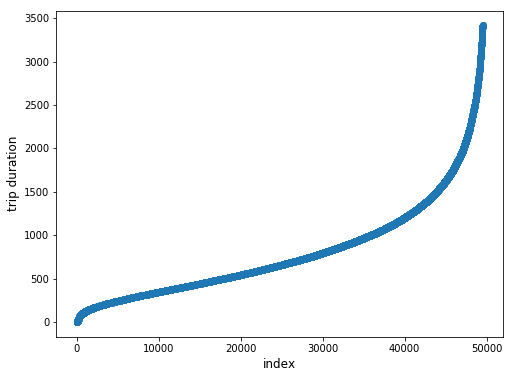

In [5]:
#Step3.2: Catch outliers and replot
th=trainDF.trip_duration.quantile(0.99)
tempDF=trainDF
tempDF=tempDF[tempDF['trip_duration']<th] #!!!!!!!!!!!!!!! Remain the ones <th
plt.figure(figsize=(8,6))
plt.scatter(range(tempDF.shape[0]),np.sort(tempDF.trip_duration.values))
plt.xlabel('index',fontsize=12)
plt.ylabel('trip duration',fontsize=12)
plt.show()
del tempDF

In [6]:
#Step 4: Dealing with missing values
variable_missing_value=trainDF.isnull().sum()
print('Missing value number of Training DF:\n',variable_missing_value)
variable_missing_value=testDF.isnull().sum()
print('Missing value number of Testing DF:\n',variable_missing_value)

Missing value number of Training DF:
 id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64
Missing value number of Testing DF:
 

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64


In [7]:
#Step 5: Format the date time & Y/N values:
from sklearn.decomposition import PCA
#Principal components analysis (PCA):illustrating how a point cloud can be very flat in one direction–which is where PCA comes in to choose a direction that is not flat.
from sklearn.cluster import MiniBatchKMeans

t0 = dt.datetime.now()
train = trainDF
test = testDF
del trainDF, testDF

In [10]:
train['pickup_datetime']=pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:,'pickup_date']=train['pickup_datetime'].dt.date
test.loc[:,'pickup_date']=test['pickup_datetime'].dt.date

train['dropoff_datetime']=pd.to_datetime(train.dropoff_datetime)

train['store_and_fwd_flag']=1*(train.store_and_fwd_flag.values=='Y')
test['store_and_fwd_flag']=1*(test.store_and_fwd_flag.values=='Y') #!!!!!!!!!!!!!!!!!
print(list(train))

['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


In [11]:
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds()) #!!!!!!!!! 1. New column 2. Convert to seconds.
duration_difference=train[np.abs(train['check_trip_duration'].values-train['trip_duration'].values) > 1] #!!!!!!!!!!!Remain the ones with abs>1
print('Trip_Duration & datetime are ok.')
print(list(train))

Trip_Duration & datetime are ok.
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration']


In [12]:
if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']])==0:
    print('Items of Duration_difference are 0.')

train['trip_duration'].describe()


count    50000.000000
mean       949.708280
std       3175.391374
min          1.000000
25%        395.000000
50%        659.000000
75%       1071.000000
max      86357.000000
Name: trip_duration, dtype: float64

In [13]:
#Step6: Feature Extraction:
coords=np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                  train[['dropoff_latitude', 'dropoff_longitude']].values,
                  test[['pickup_latitude', 'pickup_longitude']].values,
                  test[['dropoff_latitude', 'dropoff_longitude']].values))

pca=PCA().fit(coords)
train['pickup_pca0']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,0] 
#transform(X):Apply dimensionality reduction to X.
train['pickup_pca1']=pca.transform(train[['pickup_latitude','pickup_longitude']])[:,1]
train['dropoff_pca0']=pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:,0]
train['dropoff_pca1']=pca.transform(train[['dropoff_latitude','dropoff_longitude']])[:,1]

test['pickup_pca0']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,0]
test['pickup_pca1']=pca.transform(test[['pickup_latitude','pickup_longitude']])[:,1]
test['dropoff_pca0']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,0]
test['dropoff_pca1']=pca.transform(test[['dropoff_latitude','dropoff_longitude']])[:,1]
#[ : , 0 ] means (more or less) [ first_row:last_row , column_0 ],you get all values in column 0 (from all rows).
#df[['a','b']]: select multiple columns.

## For haversine_Array: http://mlwhiz.com/blog/2017/09/14/kaggle_tricks/

In [14]:
#Step7: Distance:
def haversine_array(lat1,lng1,lat2,lng2):
    lat1,lng1,lat2,lng2=map(np.radians, (lat1,lng1,lat2,lng2))
    AVG_EARTH_RADIUS=6371 #km
    lat=lat2-lat1
    lng=lng2-lng1
    d=np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h=2*AVG_EARTH_RADIUS*np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1,lng1,lat2,lng2):
    a=haversine_array(lat1,lng1,lat1,lng2)
    b=haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1,lng1,lat2,lng2):
    AVG_EARTH_RADIUS=6371
    lng_delta_rad=np.radians(lng2-lng1)
    lat1,lng1,lat2,lng2=map(np.radians,(lat1,lng1,lat2,lng2)) #np.radians(): Convert angles from degrees to radians
    y=np.sin(lng_delta_rad)*np.cos(lat2)
    x=np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

In [15]:
print('train headers:\n',list(train))
train.loc[:,'distance_haversine']=haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'direction']=bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'pca_manhattan']=np.abs(train['dropoff_pca1']-train['pickup_pca1'])+np.abs(train['dropoff_pca0']-train['pickup_pca0'])

test.loc[:,'distance_haversine']=haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan']=dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'direction']=bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:,'pca_manhattan']=np.abs(test['dropoff_pca1']-test['pickup_pca1'])+np.abs(test['dropoff_pca0']-test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2


train headers:
 ['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1']


In [16]:
#Step8: Datetime features:
train.loc[:,'pickup_weekday']=train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_hour_weekofyear']=train['pickup_datetime'].dt.weekofyear
train.loc[:,'pickup_hour']=train['pickup_datetime'].dt.hour
train.loc[:,'pickup_minute']=train['pickup_datetime'].dt.minute
train.loc[:,'pickup_dt']=(train['pickup_datetime']-train['pickup_datetime'].min()).dt.total_seconds()
train.loc[:,'pickup_week_hour']=train['pickup_weekday']*24+train['pickup_hour']

test.loc[:,'pickup_weekday']=test['pickup_datetime'].dt.weekday
test.loc[:,'pickup_hour_weekofyear']=test['pickup_datetime'].dt.weekofyear
test.loc[:,'pickup_hour']=test['pickup_datetime'].dt.hour
test.loc[:,'pickup_minute']=test['pickup_datetime'].dt.minute
test.loc[:,'pickup_dt']=(test['pickup_datetime']-test['pickup_datetime'].min()).dt.total_seconds()
test.loc[:,'pickup_week_hour']=test['pickup_weekday']*24+test['pickup_hour']

train.loc[:,'week_delta']=train['pickup_datetime'].dt.weekday+((train['pickup_datetime'].dt.hour+(train['pickup_datetime'].dt.minute/60.0))/24.0)
test.loc[:,'week_delta']=test['pickup_datetime'].dt.weekday+((test['pickup_datetime'].dt.hour+(test['pickup_datetime'].dt.minute/60.0))/24.0)


In [17]:
#Step 8.1: Make time cyclic:
train.loc[:,'week_delta_sin']=np.sin((train['week_delta']/7)*np.pi)**2
train.loc[:,'hour_sin']=np.sin((train['pickup_hour']/24)*np.pi)**2
test.loc[:,'week_delta_sin']=np.sin((test['week_delta']/7)*np.pi)**2
test.loc[:,'hour_sin']=np.sin((test['pickup_hour']/24)*np.pi)**2

In [18]:
#Step9: Speed processing:
train.loc[:,'avg_speed_h']=1000*train['distance_haversine']/train['trip_duration']
train.loc[:,'avg_speed_m']=1000*train['distance_dummy_manhattan']/train['trip_duration']
train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],3)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],3)


In [19]:
#Step9.1: Average speed for regions:
gby_cols=['pickup_lat_bin','pickup_long_bin']
coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count=train.groupby(gby_cols).count()[['id']].reset_index() #!!!!!!!reset_index()
coord_stats=pd.merge(coord_speed, coord_count,on=gby_cols)
coord_stats=coord_stats[coord_stats['id']>100]

train.loc[:,'pickup_lat_bin']=np.round(train['pickup_latitude'],2)
train.loc[:,'pickup_long_bin']=np.round(train['pickup_longitude'],2)
train.loc[:,'center_lat_bin']=np.round(train['center_latitude'],2)
train.loc[:,'center_long_bin']=np.round(train['center_longitude'],2)
train.loc[:,'pickup_dt_bin']=(train['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line

test.loc[:,'pickup_lat_bin']=np.round(test['pickup_latitude'],2)
test.loc[:,'pickup_long_bin']=np.round(test['pickup_longitude'],2)
test.loc[:,'center_lat_bin']=np.round(test['center_latitude'],2)
test.loc[:,'center_long_bin']=np.round(test['center_longitude'],2)
test.loc[:,'pickup_dt_bin']=(test['pickup_dt']//(3*3600)) #Floor division - division that results into whole number adjusted to the left in the number line


In [20]:
#Step10: Clustering-MiniBatchKMeans:
sample_ind=np.random.permutation(len(coords))[:500000]
#np.random.permutation: Randomly permute a sequence, or return a permuted range.
#Shuffle the coords and get 500000 items from it.

print('length of coords:\n', len(coords))
kmeans=MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])
#MiniBatchKMeans: batch_size controls the number of randomly selected observations in each batch. The larger the the size of the batch, the more computationally costly the training process.


length of coords:
 1350268


In [21]:
#Step10.1: Predict by MiniBatchKMeans:
train.loc[:,'pickup_cluster']=kmeans.predict(train[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster']=kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:,'pickup_cluster']=kmeans.predict(test[['pickup_latitude','pickup_longitude']])
test.loc[:,'dropoff_cluster']=kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

t1=dt.datetime.now()
print('Time for clustering: %i seconds' %(t1-t0).seconds) #!!!!!!!!!!!!!!!!!!!!


Time for clustering: 371 seconds


In [22]:
train['log_trip_duration']=np.log(train['trip_duration'].values+1)

In [23]:
print(list(test))
print("\n")
print("Train:")
print(list(train))
print(train.head(3))

['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_cluster', 'dropoff_cluster']


Train:
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'check_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direct

In [24]:
#Step11: Temporal and geospatial aggregation
for gby_col in ['pickup_hour','pickup_date','pickup_dt_bin','pickup_week_hour','pickup_cluster','dropoff_cluster']:
    gby=train.groupby(gby_col).mean()[['avg_speed_h','avg_speed_m','log_trip_duration']]
    gby.columns=['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train=pd.merge(train, gby,how='left',left_on=gby_col,right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)
    #how: left: use only keys from left frame, similar to a SQL left outer join; preserve key order
    #right_index: Use the index from the right DataFrame as the join key.
    #left_on 和 right_on 来指定列名，从而使不同的列名相互对应，进而进行合并. 如employee, name.


for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed=train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count=train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats=pd.merge(coord_speed,coord_count,on=gby_cols)
    coord_stats.columns=gby_cols+['avg_speed_h_%s' % '_'.join(gby_cols),'cnt_%s' % '_'.join(gby_cols)]
    #.columns attribute returns an index containg the column names of df.df. columns可以得到所有的列标签，同理df.index可以得到所有的行标签。
    #eg.:df.columns: Get: Index(['ColumnOne', 'ColumnTwo'], dtype=
    train=pd.merge(train,coord_stats,how='left',on=gby_cols)
    test=pd.merge(test,coord_stats,how='left',on=gby_cols)
 

In [25]:
print(list(test))
print("\n")
print("Train:")
print(list(train))
print(train.head(3))


['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_date', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_

In [26]:
   
group_freq = '60min'
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['pickup_datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['pickup_datetime'].dt.round(group_freq)
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag          ...            \
0         40.765602                   0          ...             
1         40.731152                   0          ...             
2         40.710087                   0          ...             

   cnt_center_lat_bin_center_long_bin  \
0                                2020   
1                                1803   
2                                2823 

In [27]:
# Count trips over 60min
df_counts = df_all.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['id']
train = train.merge(df_counts, on='id', how='left')
test = test.merge(df_counts, on='id', how='left')
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag     ...       \
0         40.765602                   0     ...        
1         40.731152                   0     ...        
2         40.710087                   0     ...        

   avg_speed_h_pickup_hour_center_lat_bin_center_long_bin  \
0                                           3.045406        
1                                           3.419741        
2                 

In [28]:
# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'dropoff_cluster_count'})

In [29]:
train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [30]:
# Count how many trips are going from each cluster over time
df_all = pd.concat((train, test))[['id', 'pickup_datetime', 'pickup_cluster', 'dropoff_cluster']]
pickup_counts = df_all \
    .set_index('pickup_datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'pickup_cluster']) \
    .agg({'id': 'count'}) \
    .reset_index().set_index('pickup_datetime') \
    .groupby('pickup_cluster').rolling('240min').mean() \
    .drop('pickup_cluster', axis=1) \
    .reset_index().set_index('pickup_datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'pickup_datetime': 'pickup_datetime_group', 'id': 'pickup_cluster_count'})

In [31]:
train['pickup_cluster_count'] = train[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)
test['pickup_cluster_count'] = test[['pickup_datetime_group', 'pickup_cluster']].merge(pickup_counts, on=['pickup_datetime_group', 'pickup_cluster'], how='left')['pickup_cluster_count'].fillna(0)


In [32]:
# For this particular problem we can add OSRM ([Open Source Routing Machine](http://project-osrm.org/ 
# "OSRM")) features. This data contains the fastest routes from specific starting points in NY.

fr1 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv',
                  usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])

fr2 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv',
                  usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

test_street_info = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
                               usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])


In [33]:
train_street_info=pd.concat((fr1, fr2))
train = train.merge(train_street_info, how='left', on='id')
test = test.merge(test_street_info, how='left', on='id')
print(train.head(3))

          id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:00 2016-03-14 17:32:00   
1  id2377394          1 2016-06-12 00:43:00 2016-06-12 00:54:00   
2  id3858529          2 2016-01-19 11:35:00 2016-01-19 12:10:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   

   dropoff_latitude  store_and_fwd_flag       ...         \
0         40.765602                   0       ...          
1         40.731152                   0       ...          
2         40.710087                   0       ...          

   cnt_pickup_hour_dropoff_cluster avg_speed_h_pickup_cluster_dropoff_cluster  \
0                               70                                   2.943386   
1                      

In [34]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['id', 'log_trip_duration', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin', 'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()

t1 = dt.datetime.now()
print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'check_trip_duration' 'dropoff_datetime'
 'log_trip_duration' 'trip_duration']
We have 62 features.
Feature extraction time: 441 seconds


In [35]:
feature_stats = pd.DataFrame({'feature': feature_names})

feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()


,feature,train_test_mean_diff
55,cnt_pickup_cluster_dropoff_cluster,0.031627
51,cnt_pickup_hour_pickup_cluster,0.036648
53,cnt_pickup_hour_dropoff_cluster,0.041682
48,avg_speed_h_pickup_hour_center_lat_bin_center_...,0.045448
6,store_and_fwd_flag,NaN


In [36]:
from tpot import TPOTRegressor
auto_classifier = TPOTRegressor(generations=3, population_size=9, verbosity=2)
from sklearn.model_selection import train_test_split

C:\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


C:\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [37]:
# Split the training data to train and validate

# K Fold Cross Validation
from sklearn.model_selection import KFold

X = train[feature_names].values
y = np.log(train['trip_duration'].values + 1) 

kf = KFold(n_splits=10)
kf.get_n_splits(X)

print("feature names:\n", feature_names)
print("x:\n",X)
print("y:\n",y)
print(kf)  


feature names:


['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip

x:


[[  2.00000000e+00   1.00000000e+00  -7.39821549e+01 ...,   2.00910000e+03
    1.64900000e+02   5.00000000e+00]
 [  1.00000000e+00   1.00000000e+00  -7.39804153e+01 ...,   2.51320000e+03
    3.32000000e+02   6.00000000e+00]
 [  2.00000000e+00   1.00000000e+00  -7.39790268e+01 ...,   1.10608000e+04
    7.67600000e+02   1.60000000e+01]
 ..., 
 [  1.00000000e+00   1.00000000e+00  -7.39679794e+01 ...,   5.20500000e+03
    5.20000000e+02   6.00000000e+00]
 [  2.00000000e+00   2.00000000e+00  -7.37767410e+01 ...,   1.89727000e+04
    1.17050000e+03   1.70000000e+01]
 [  1.00000000e+00   2.00000000e+00  -7.40147934e+01 ...,   3.93740000e+03
    4.24700000e+02   6.00000000e+00]]

y:


[ 6.12249281  6.49828215  7.66152708 ...,  6.85856503  7.47363711
  6.42162227]

KFold(n_splits=10, random_state=None, shuffle=False)

In [38]:
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]

TRAIN:

[ 5000  5001  5002 ..., 49997 49998 49999]

TEST:

[   0    1    2 ..., 4997 4998 4999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[5000 5001 5002 ..., 9997 9998 9999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[10000 10001 10002 ..., 14997 14998 14999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[15000 15001 15002 ..., 19997 19998 19999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[20000 20001 20002 ..., 24997 24998 24999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[25000 25001 25002 ..., 29997 29998 29999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[30000 30001 30002 ..., 34997 34998 34999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[35000 35001 35002 ..., 39997 39998 39999]

TRAIN:

[    0     1     2 ..., 49997 49998 49999]

TEST:

[40000 40001 40002 ..., 44997 44998 44999]

TRAIN:

[    0     1     2 ..., 44997 44998 44999]

TEST:

[45000 45001 45002 ..., 49997 49998 49999]

In [39]:
auto_classifier.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/36 [00:00<?, ?pipeline/s]

Optimization Progress:   3%|▎         | 1/36 [00:10<06:10, 10.59s/pipeline]

Optimization Progress:   6%|▌         | 2/36 [00:16<05:12,  9.20s/pipeline]

Optimization Progress:   8%|▊         | 3/36 [02:25<24:47, 45.07s/pipeline]

Optimization Progress:  11%|█         | 4/36 [02:26<17:04, 32.02s/pipeline]

Optimization Progress:  14%|█▍        | 5/36 [02:54<15:47, 30.58s/pipeline]

Optimization Progress:  17%|█▋        | 6/36 [04:40<26:41, 53.38s/pipeline]

Optimization Progress:  19%|█▉        | 7/36 [06:20<32:29, 67.21s/pipeline]

Optimization Progress:  22%|██▏       | 8/36 [08:12<37:44, 80.89s/pipeline]

Optimization Progress:  25%|██▌       | 9/36 [10:20<42:42, 94.92s/pipeline]

Optimization Progress:  28%|██▊       | 10/36 [12:21<44:32, 102.79s/pipeline]

Optimization Progress:  31%|███       | 11/36 [13:49<40:56, 98.25s/pipeline] 

Optimization Progress:  33%|███▎      | 12/36 [15:58<43:02, 107.59s/pipeline]

Optimization Progress:  36%|███▌      | 13/36 [16:00<29:05, 75.90s/pipeline] 

Optimization Progress:  39%|███▉      | 14/36 [17:39<30:17, 82.61s/pipeline]

Optimization Progress:  42%|████▏     | 15/36 [18:13<23:49, 68.05s/pipeline]

Optimization Progress:  44%|████▍     | 16/36 [19:57<26:20, 79.04s/pipeline]

Optimization Progress:  47%|████▋     | 17/36 [20:03<18:01, 56.94s/pipeline]

Optimization Progress:  50%|█████     | 18/36 [27:26<51:49, 172.76s/pipeline]

Generation 1 - Current best internal CV score: -0.15839809861359572

Optimization Progress:  53%|█████▎    | 19/36 [27:26<48:56, 172.76s/pipeline]

Optimization Progress:  53%|█████▎    | 19/36 [27:27<34:20, 121.22s/pipeline]

Optimization Progress:  56%|█████▌    | 20/36 [27:36<23:21, 87.61s/pipeline] 

Optimization Progress:  58%|█████▊    | 21/36 [32:36<37:51, 151.44s/pipeline]

Optimization Progress:  64%|██████▍   | 23/36 [34:30<26:40, 123.11s/pipeline]

Optimization Progress:  67%|██████▋   | 24/36 [36:30<24:24, 122.04s/pipeline]

Optimization Progress:  69%|██████▉   | 25/36 [36:37<16:04, 87.71s/pipeline] 

Optimization Progress:  72%|███████▏  | 26/36 [36:45<10:37, 63.79s/pipeline]

Optimization Progress:  75%|███████▌  | 27/36 [36:48<06:49, 45.51s/pipeline]

Optimization Progress:  78%|███████▊  | 28/36 [36:57<04:36, 34.60s/pipeline]

Optimization Progress:  81%|████████  | 29/36 [37:52<04:43, 40.51s/pipeline]

Generation 2 - Current best internal CV score: -0.15839809861359572

Optimization Progress:  81%|████████  | 29/36 [37:52<04:43, 40.51s/pipeline]

Optimization Progress:  83%|████████▎ | 30/36 [37:52<02:51, 28.54s/pipeline]

Optimization Progress:  86%|████████▌ | 31/36 [38:02<01:54, 22.89s/pipeline]

Optimization Progress:  89%|████████▉ | 32/36 [38:08<01:11, 17.81s/pipeline]

Optimization Progress:  92%|█████████▏| 33/36 [38:27<00:54, 18.15s/pipeline]

Optimization Progress:  94%|█████████▍| 34/36 [40:37<01:43, 51.80s/pipeline]

Optimization Progress:  97%|█████████▋| 35/36 [43:02<01:19, 79.69s/pipeline]

Optimization Progress: 100%|██████████| 36/36 [43:09<00:00, 57.85s/pipeline]

Optimization Progress: 37pipeline [44:15, 60.22s/pipeline]                  

Optimization Progress: 38pipeline [45:35, 66.33s/pipeline]

Generation 3 - Current best internal CV score: -0.15839809861359572

Optimization Progress: 38pipeline [45:35, 66.33s/pipeline]

Best pipeline:

GradientBoostingRegressor(input_matrix, alpha=0.95, learning_rate=0.5, loss=ls, max_depth=4, max_features=0.45, min_samples_leaf=14, min_samples_split=6, n_estimators=100, subsample=0.95)

TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraT....45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=3, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=9, periodic_checkpoint_folder=None,
       population_size=9, random_state=None, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

In [40]:
print(feature_names)
print(test[feature_names].head(5))
test[feature_names].to_csv('NYCTaxi_DataTest.csv', index=False)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_dummy_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'week_delta', 'week_delta_sin', 'hour_sin', 'pickup_cluster', 'dropoff_cluster', 'avg_speed_h_gby_pickup_hour', 'avg_speed_m_gby_pickup_hour', 'log_trip_duration_gby_pickup_hour', 'avg_speed_h_gby_pickup_date', 'avg_speed_m_gby_pickup_date', 'log_trip_duration_gby_pickup_date', 'avg_speed_h_gby_pickup_dt_bin', 'avg_speed_m_gby_pickup_dt_bin', 'log_trip_duration_gby_pickup_dt_bin', 'avg_speed_h_gby_pickup_week_hour', 'avg_speed_m_gby_pickup_week_hour', 'log_trip_duration_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster', 'avg_speed_m_gby_pickup_cluster', 'log_trip

   vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0          1                1        -73.988129        40.732029   
1          1                1        -73.964203        40.679993   
2          1                1        -73.997437        40.737583   
3          2                1        -73.956070        40.771900   
4          1                1        -73.970215        40.761475   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_pca0  \
0         -73.990173         40.756680                   0     0.016106   
1         -73.959808         40.655403                   0    -0.003569   
2         -73.986160         40.729523                   0     0.024939   
3         -73.986427         40.730469                   0    -0.019047   
4         -73.961510         40.755890                   0    -0.004111   

   pickup_pca1  dropoff_pca0       ...         \
0    -0.018128      0.016167       ...          
1    -0.071915     -0.005977       ...    

In [41]:
test_result = auto_classifier.predict(test[feature_names].values)
sub = pd.DataFrame()
sub['id'] = test['id']
sub['trip_duration'] = np.exp(test_result)
sub['pickup_weekday']=test['pickup_weekday']
sub.to_csv('NYCTaxi_TpotModels.csv', index=False)
sub.head()
      
auto_classifier.export('NYCTaxi_TPOTpipelineResult.py')

Imputing missing values in feature set

True

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation, metrics

exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=13, min_samples_split=12, n_estimators=100)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_valid)



C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
trainDF = pd.read_csv('NYCTaxi_DataTest.csv', nrows=10000)
print(trainDF.isnull().any())

vendor_id                                                 False
passenger_count                                           False
pickup_longitude                                          False
pickup_latitude                                           False
dropoff_longitude                                         False
dropoff_latitude                                          False
store_and_fwd_flag                                        False
pickup_pca0                                               False
pickup_pca1                                               False
dropoff_pca0                                              False
dropoff_pca1                                              False
distance_haversine                                        False
distance_dummy_manhattan                                  False
direction                                                 False
pca_manhattan                                             False
center_latitude                         

In [44]:
#Fill nan of columns:
trainDF['avg_speed_h_center_lat_bin_center_long_bin'].fillna((trainDF['avg_speed_h_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['cnt_center_lat_bin_center_long_bin'].fillna((trainDF['cnt_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_center_lat_bin_center_long_bin'].fillna((trainDF['avg_speed_h_pickup_hour_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['cnt_pickup_hour_center_lat_bin_center_long_bin'].fillna((trainDF['cnt_pickup_hour_center_lat_bin_center_long_bin'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_pickup_cluster'].fillna((trainDF['avg_speed_h_pickup_hour_pickup_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_hour_pickup_cluster'].fillna((trainDF['cnt_pickup_hour_pickup_cluster'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_hour_dropoff_cluster'].fillna((trainDF['avg_speed_h_pickup_hour_dropoff_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_hour_dropoff_cluster'].fillna((trainDF['cnt_pickup_hour_dropoff_cluster'].mean()), inplace=True)
trainDF['avg_speed_h_pickup_cluster_dropoff_cluster'].fillna((trainDF['avg_speed_h_pickup_cluster_dropoff_cluster'].mean()), inplace=True)
trainDF['cnt_pickup_cluster_dropoff_cluster'].fillna((trainDF['cnt_pickup_cluster_dropoff_cluster'].mean()), inplace=True)


#  Animation the map with time changing:

In [45]:
import pandas as pd  #pandas for using dataframe and reading csv 
import numpy as np   #numpy for vector operations and basic maths 
#import simplejson    #getting JSON in simplified format
import urllib        #for url stuff
#import gmaps       #for using google maps to visulalize places on maps
import re            #for processing regular expressions
import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
import scipy         #for other dependancies
from sklearn.cluster import KMeans # for doing K-means clustering
from haversine import haversine # for calculating haversine distance
import math          #for basic maths operations
import seaborn as sns #for making plots
import matplotlib.pyplot as plt # for plotting
import os  # for os commands
# from scipy.misc import imread, imresize, imsave  # for plots 
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
import io
import base64
output_notebook()
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

<div class="bk-root">
        <a href="https://bokeh.pydata.org" target="_blank" class="bk-logo bk-logo-small bk-logo-notebook"></a>
        <span id="daecbb11-67f8-4e67-91a0-dd8fc960a311">Loading BokehJS ...</span>
    </div>

<div class="bk-root">
        <a href="https://bokeh.pydata.org" target="_blank" class="bk-logo bk-logo-small bk-logo-notebook"></a>
        <span id="daecbb11-67f8-4e67-91a0-dd8fc960a311">Loading BokehJS ...</span>
    </div>

In [46]:
s = time.time()
train_fr_1 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv')
train_fr_2 = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv')
train_fr = pd.concat([train_fr_1, train_fr_2])
train_fr_new = train_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

train_df = pd.read_csv('data/new-york-city-taxi-with-osrm/train.csv')
train = pd.merge(train_df, train_fr_new, on = 'id', how = 'left')
train_df = train.copy()
end = time.time()
print("Time taken: {}.".format((end-s)))

Time taken: 39.47292947769165.

In [47]:
# checking if Ids are unique, and the number of Nulls.
start = time.time()
train_data = train_df.copy()
start = time.time()
print("Respectively, number of columns and rows and columns are {} and {} .".format(train_data.shape[1], train_data.shape[0]))
if train_data.id.nunique() == train_data.shape[0]: #nunique(): Return number of unique elements in the object.
    print("Train ids are unique")
print("Number of Nulls : {}.".format(train_data.isnull().sum().sum()))

# Remain the items with latitude & longitude between 40.6-40.9 and -74.05--73.7:
%matplotlib inline

df = train_df.loc[(train_df.pickup_latitude > 40.6) & (train_df.pickup_latitude < 40.9)]
df = df.loc[(df.dropoff_latitude>40.6) & (df.dropoff_latitude < 40.9)]
df = df.loc[(df.dropoff_longitude > -74.05) & (df.dropoff_longitude < -73.7)]
df = df.loc[(df.pickup_longitude > -74.05) & (df.pickup_longitude < -73.7)]

train_data_new = df.copy()
print(train_data_new.head(4))
end = time.time()
print("Time taken {}.".format(end-start))

Respectively, number of columns and rows and columns are 14 and 1458644 .

Train ids are unique

Number of Nulls : 3.

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   

   dropoff_latitude store_and_fwd_flag  trip_duration  total_distance  \
0         40.765602                  N            455          2009.1   
1         40.731152                  N            663          2513.2   
2         40.710087                  N           2124 

Time taken 6.963511228561401.

In [48]:
temp = train_data.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_date'] = train_data['pickup_datetime'].dt.date
train_data.head()

ts_v1 = pd.DataFrame(train_data.loc[train_data['vendor_id']==1].groupby('pick_date')['trip_duration'].mean())
ts_v1.reset_index(inplace = True)
ts_v2 = pd.DataFrame(train_data.loc[train_data.vendor_id==2].groupby('pick_date')['trip_duration'].mean())
ts_v2.reset_index(inplace = True)

train_data = temp


#  Basic image processing

##  Consider each point of this image as a point represented by lat-long
## Then take a summary of lat-long and their count, assign a different color for different count range.

In [49]:
# Create 3 arrays: with 3500 rows & 3 columns each.
start = time.time()
rgb = np.zeros((3000, 3500, 3), dtype=np.uint8) # 3000 arrays: with 3500 rows & 3 columns each.
rgb[..., 0] = 0 # Assign 0 to every items in column 0;
rgb[..., 1] = 0 # Assign 0 to every items in column 1;
rgb[..., 2] = 0 # Assign 0 to every items in column 2;

train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))
# map(): typecasting every element of the list to an integer value. 
# latitude should be between 40.6 to 40.9; Longitude should be between -74.05 to -73.70
summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

#Print new train data after transformation:
('pickup_latitude:\n',train_data_new['pick_lat_new'].head(3))
print('dropoff_latitude:\n',train_data_new['drop_lat_new'].head(3))
print('pickup_longitude:\n',train_data_new['pick_lon_new'].head(3))
print('dropoff_longitude:\n',train_data_new['drop_lon_new'].head(3))
# print('summary_plot:\n')
# summary_plot.head(100)

dropoff_latitude:


0    1656
1    1311
2    1100
Name: drop_lat_new, dtype: int64

pickup_longitude:


0    678
1    695
2    709
Name: pick_lon_new, dtype: int64

dropoff_longitude:


0    853
1    505
2    446
Name: drop_lon_new, dtype: int64

Time taken by above cell is 1768.0888392925262.

unit:

[1]

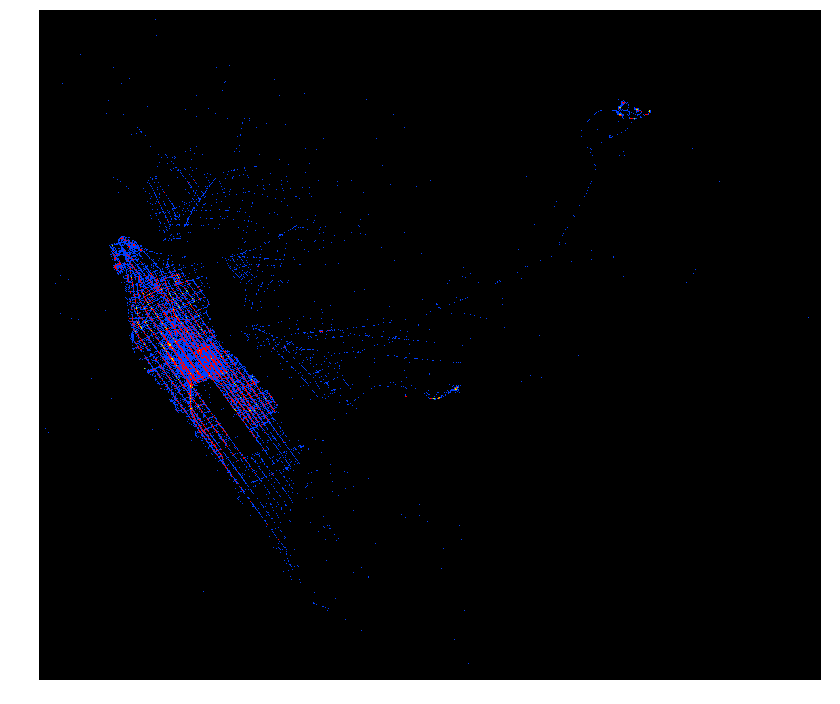

In [51]:
#Plot geograph:
summary_plot.reset_index(inplace = True)
summary_plot.head(120)
lat_list = summary_plot['pick_lat_new'].unique()

for i in lat_list: #lat_list: list of unique 'pick_lat_new'
    lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
    # Get the longitude mapping with unique latitude.
    unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
    # Get the id mapping with unique latitude.
    
    for j in lon_list: 
        a = unit[lon_list.index(j)] # lon_list.index(j): return the index of lon_list(j)
        if (a//50) >0: # //: Floor Division: the result is the quotient in which the digits after decimal points are not taken into account.
            rgb[i,j, 0] = 191 #Label the count>50 with Green
            rgb[i,j, 1] = 255
            rgb[i,j, 2] = 0
        elif (a//10)>0: #Label the count>10 with Red
            rgb[i,j, 0] = 255
            rgb[i,j, 1] = 0
            rgb[i,j, 2] = 0
        else: #Label the count>10 with blue
            rgb[i,j, 0] = 0
            rgb[i,j, 1] = 64
            rgb[i,j, 2] = 255

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,20))
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))
ax.imshow(rgb, cmap = 'hot')
ax.set_axis_off() 

print('unit:',unit)


# Feature Extraction:

## Define funtions to unfold features:
##  Find out features which are affecting the trip-duration between a given pickup and drop-off locations. 

## The bearing & manhattan distance: https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367

In [52]:

start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Time taken by above cell is 0.0005002021789550781.

##Feature extratction

In [53]:
start = time.time()
train_data = temp.copy()
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime)
train_data.loc[:, 'pick_month'] = train_data['pickup_datetime'].dt.month
train_data.loc[:, 'hour'] = train_data['pickup_datetime'].dt.hour
train_data.loc[:, 'week_of_year'] = train_data['pickup_datetime'].dt.weekofyear
train_data.loc[:, 'day_of_year'] = train_data['pickup_datetime'].dt.dayofyear
train_data.loc[:, 'day_of_week'] = train_data['pickup_datetime'].dt.dayofweek
train_data.loc[:,'hvsine_pick_drop'] = haversine_(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
train_data.loc[:,'bearing'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 5.975921392440796.

# Animation of pickups
## Make an animation of pickup and see how with pickup hours the traffic changes

In [54]:
# making similar heatmaps of pickup locations for different pickup hours，
# and then will make a gif of those images in order of increasing pickup hour.

start = time.time()
def color(hour):
    """function for color change in animation"""
    return(10*hour)

def Animation(hour, temp, rgb):
    """Function to generate return a pic of plotings"""
    train_data_new = temp.loc[temp['hour'] == hour]
    start = time.time()
    rgb = np.zeros((3000, 3500, 3), dtype=np.uint8)
    rgb[..., 0] = 0
    rgb[..., 1] = 0
    rgb[..., 2] = 0
    train_data_new['pick_lat_new'] = list(map(int, (train_data_new['pickup_latitude'] - (40.6000))*10000))
    train_data_new['drop_lat_new'] = list(map(int, (train_data_new['dropoff_latitude'] - (40.6000))*10000))
    train_data_new['pick_lon_new'] = list(map(int, (train_data_new['pickup_longitude'] - (-74.050))*10000))
    train_data_new['drop_lon_new'] = list(map(int,(train_data_new['dropoff_longitude'] - (-74.050))*10000))

    summary_plot = pd.DataFrame(train_data_new.groupby(['pick_lat_new', 'pick_lon_new'])['id'].count())

    summary_plot.reset_index(inplace = True)
    summary_plot.head(120)
    lat_list = summary_plot['pick_lat_new'].unique()
    for i in lat_list:
        #print(i)
        lon_list = summary_plot.loc[summary_plot['pick_lat_new']==i]['pick_lon_new'].tolist()
        unit = summary_plot.loc[summary_plot['pick_lat_new']==i]['id'].tolist()
        for j in lon_list:
            #j = int(j)
            a = unit[lon_list.index(j)]
            #print(a)
            if (a//50) >0:
                rgb[i][j][0] = 255 - color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            elif (a//10)>0:
                rgb[i,j, 0] = 0 + color(hour)
                rgb[i,j, 1] = 255 - color(hour)
                rgb[i,j, 2] = 0 + color(hour)
            else:
                rgb[i,j, 0] = 255 - color(hour)
                rgb[i,j, 1] = 0 + color(hour)
                rgb[i,j, 2] = 0 + color(hour)

    end = time.time()
    print("Time taken by above cell is {} for {}.".format((end-start), hour))
    return(rgb)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

Time taken by above cell is 0.0005016326904296875.

In [57]:
start = time.time()
images_list=[]
train_data_new['pickup_datetime'] = pd.to_datetime(train_data_new.pickup_datetime)
train_data_new.loc[:, 'hour'] = train_data_new['pickup_datetime'].dt.hour

for i in list(range(0, 24)):
    im = Animation(i, train_data_new, rgb.copy())
    images_list.append(im)
end = time.time()
print("Time taken by above cell is {}.".format(end -start))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Time taken by above cell is 9.380939483642578 for 0.

Time taken by above cell is 10.390117883682251 for 1.

Time taken by above cell is 5.593869686126709 for 2.

Time taken by above cell is 4.025700092315674 for 3.

Time taken by above cell is 3.697329044342041 for 4.

Time taken by above cell is 4.612783193588257 for 5.

Time taken by above cell is 4.463865280151367 for 6.

Time taken by above cell is 4.6969828605651855 for 7.

Time taken by above cell is 4.539067506790161 for 8.

Time taken by above cell is 4.350067138671875 for 9.

Time taken by above cell is 4.156048774719238 for 10.

Time taken by above cell is 3.844219446182251 for 11.

Time taken by above cell is 4.404720306396484 for 12.

Time taken by above cell is 4.267845392227173 for 13.

Time taken by above cell is 4.366607666015625 for 14.

Time taken by above cell is 4.175601959228516 for 15.

Time taken by above cell is 3.8788111209869385 for 16.

Time taken by above cell is 4.339536190032959 for 17.

Time taken by above cell is 4.544589996337891 for 18.

Time taken by above cell is 4.442810773849487 for 19.

Time taken by above cell is 4.386662006378174 for 20.

Time taken by above cell is 4.123459339141846 for 21.

Time taken by above cell is 5.025362968444824 for 22.

Time taken by above cell is 4.466895341873169 for 23.

Time taken by above cell is 118.72465682029724.

In [57]:
start = time.time()

def build_gif(imgs = images_list, show_gif=False, save_gif=True, title=''):
    """function to create a gif of heatmaps"""
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    ax.set_axis_off()
    hr_range = list(range(0,24))
    def show_im(pairs):
        ax.clear()
        ax.set_title('Absolute Traffic - Hour ' + str(int(pairs[0])) + ':00')
        ax.imshow(pairs[1])
        ax.set_axis_off() 
    pairs = list(zip(hr_range, imgs))
    #ims = map(lambda x: (ax.imshow(x), ax.set_title(title)), imgs)
    im_ani = animation.FuncAnimation(fig, show_im, pairs,interval=500, repeat_delay=0, blit=False)
    plt.cla()
    if save_gif:
        plt.rcParams["animation.convert_path"] = "C:\DataAnalytics\ImageMagick-7.0.7-Q16\convert.exe" #magick.exe
        im_ani.save('animation.gif', writer='imagemagick') #, writer='imagemagick'
    if show_gif:
        plt.show()
    return
end = time.time()
print("Time taken by above cell is {}".format(end-start))

Time taken by above cell is 0.0005016326904296875

21.703890085220337

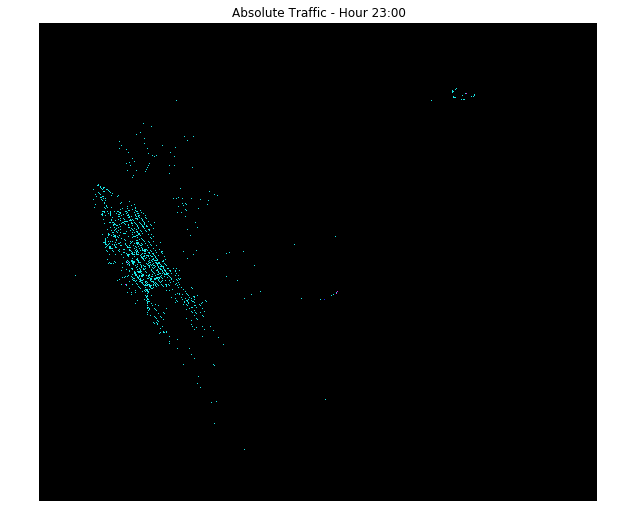

In [58]:
start = time.time()
build_gif()
end = time.time()
print(end-start)

In [59]:
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## Check the changing .gif on Notebook.
## Findings:
## 1. The least number of request comes from time 2 AM-7 AM, from 7 AM -4 PM the requests were moderate in number, and from 5 PM-1 AM in night, there is a huge amount of request of cabs in all NYC.
## 2. The dot in the top right corner of this animation is JFK Airport: people are moving less between 2 AM to 6 AM with same rules.

# Features' Exploration (Checking if any explainable pattern)

## check the average time taken by two different vendors vs weekday

C:\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning:

The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.



0.492372989654541

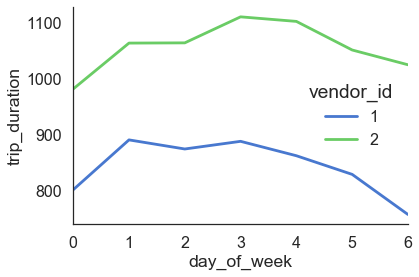

In [60]:
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(train_data.groupby(['vendor_id','day_of_week'])['trip_duration'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_wdays_avg_duration, time="day_of_week", unit = "unit", condition="vendor_id", value="trip_duration")
sns.despine(bottom = False)
end = time.time()
print(end - start)

## Findings:
1. Vendor 1 is taking more time than vendor 2 on all the days of the week, we can also subset data frame based on the month and that will also give us the same results.  
2. The difference between the average time taken by vendor 1 is ~250 seconds more than vendor 2.

# Cluster analysis and visualization

In [61]:
start = time.time()
def assign_cluster(df, k):
    """function to assign clusters """
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]
    """I am using initialization as from the output of
    k-means from my local machine to save time in this kernel"""
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(df_pick)
    clust_pick = k_means_pick.labels_
    df['label_pick'] = clust_pick.tolist()
    df['label_drop'] = k_means_pick.predict(df_drop)
    return df, k_means_pick

end = time.time()
print("time taken by thie script by now is {}.".format(end-start))

time taken by thie script by now is 0.0005009174346923828.

In [62]:
start = time.time()
train_cl, k_means = assign_cluster(train_data, 20)  # make it 100 when extracting features 
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
#centroid_pickups.head()
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])
#train_cl.head()
end = time.time()
print("Time taken in clustering is {}.".format(end - start))

Time taken in clustering is 4.570148944854736.

# Cluster related features

## Distance (haversine, mahnatten) between pickup-drop_off cluster centroids
## Directional features - bearing direction between cluster centroids

In [63]:
start = time.time()
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl['speed_hvsn'] = train_cl.hvsine_pick_drop/train_cl.total_travel_time
train_cl['speed_manhtn'] = train_cl.manhtn_pick_drop/train_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))
train_cl.head()

Time Taken by above cell is 5.651033639907837.

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,1.098585,2.319857,1.338601,1.549840,2.822553,8.812218,-138.980503,165.640915,0.009087,0.010524
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0.845448,1.520191,1.573052,0.968702,2.144236,-149.031278,-9.113659,-49.174617,0.005438,0.007321
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0.508922,5.718571,1.135490,0.690697,7.848844,142.642889,-28.669171,-148.907292,0.008318,0.010687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0.888828,0.000000,0.805089,1.161466,0.000000,166.837718,22.515049,0.000000,0.006300,0.007046
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0.755820,0.000000,2.237846,1.060322,0.000000,-160.438403,-127.746230,0.000000,0.008484,0.008561


# Cluster visualization using folium

## In the next, cluster summary function is to find the cluster characteristics of given cluster list( a cluster list is the list of significant clusters, not all clusters are significant in size.) So, a list of the significant cluster can be passed to summarized those clusters. Significant clusters are clusters having more than 70 thousand rides as the pickup location. Then we will make plots:
## 1. Showing pickups location on NYC map using stamen toner terrain
## 2. Showing all clusters on Map of America

In [64]:
start = time.time()
def cluster_summary(sum_df):
    """function to calculate summary of given list of clusters """
    #agg_func = {'trip_duration':'mean','label_drop':'count','bearing':'mean','id':'count'} # that's how you use agg function with groupby
    summary_avg_time = pd.DataFrame(sum_df.groupby('label_pick')['trip_duration'].mean())
    summary_avg_time.reset_index(inplace = True)
    summary_pref_clus = pd.DataFrame(sum_df.groupby(['label_pick', 'label_drop'])['id'].count())
    summary_pref_clus = summary_pref_clus.reset_index()
    summary_pref_clus = summary_pref_clus.loc[summary_pref_clus.groupby('label_pick')['id'].idxmax()]
    summary =pd.merge(summary_avg_time, summary_pref_clus, how = 'left', on = 'label_pick')
    summary = summary.rename(columns={'trip_duration':'avg_triptime'})
    return summary
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 0.0005011558532714844.

## Folium citing: http://folium.readthedocs.io/en/latest/quickstart.html

In [100]:
import folium
def show_fmaps(train_data, path=1):
    """function to generate map and add the pick up and drop coordinates
    1. Path = 1 : Join pickup (blue) and drop(red) using a straight line
    """
    full_data = train_data
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    # map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10,tiles='Stamen Toner') 
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=10)
    # manually added centre
    new_df = train_data.loc[train_data['label_pick'].isin(summary_full_data.label_pick.tolist())].sample(50)
    new_df.reset_index(inplace = True, drop = True)
    for i in range(new_df.shape[0]):
        pick_long = new_df.loc[new_df.index ==i]['pickup_longitude'].values[0]
        pick_lat = new_df.loc[new_df.index ==i]['pickup_latitude'].values[0]
        dest_long = new_df.loc[new_df.index ==i]['dropoff_longitude'].values[0]
        dest_lat = new_df.loc[new_df.index ==i]['dropoff_latitude'].values[0]
        folium.Marker([pick_lat, pick_long]).add_to(map_1)
        folium.Marker([dest_lat, dest_long]).add_to(map_1)
    return map_1

def clusters_map(clus_data, full_data, tile = 'OpenStreetMap', sig = 0, zoom = 12, circle = 0, radius_ = 30):
    """ function to plot clusters on map"""
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=zoom,tiles= tile) # 'Mapbox' 'Stamen Toner'
    summary_full_data = pd.DataFrame(full_data.groupby('label_pick')['id'].count())
    summary_full_data.reset_index(inplace = True)
    if sig == 1:
        summary_full_data = summary_full_data.loc[summary_full_data['id']>70000]
    sig_cluster = summary_full_data['label_pick'].tolist()
    clus_summary = cluster_summary(full_data)
    for i in sig_cluster:
        pick_long = clus_data.loc[clus_data.index ==i]['centroid_pick_long'].values[0]
        pick_lat = clus_data.loc[clus_data.index ==i]['centroid_pick_lat'].values[0]
        clus_no = clus_data.loc[clus_data.index ==i]['label_pick'].values[0]
        most_visited_clus = clus_summary.loc[clus_summary['label_pick']==i]['label_drop'].values[0]
        avg_triptime = clus_summary.loc[clus_summary['label_pick']==i]['avg_triptime'].values[0]
        pop = 'cluster = '+str(clus_no)+' & most visited cluster = ' +str(most_visited_clus) +' & avg triptime from this cluster =' + str(avg_triptime)
        if circle == 1:
            folium.CircleMarker(location=[pick_lat, pick_long], radius=radius_,
                    color='#F08080',
                    fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([pick_lat, pick_long], popup=pop).add_to(map_1)
    return map_1

In [101]:
osm = show_fmaps(train_data, path=1)
osm

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxoZWFkPiAgICAKICAgIDxtZXRhIGh0dHAtZXF1aXY9ImNvbnRlbnQtdHlwZSIgY29udGVudD0idGV4dC9odG1sOyBjaGFyc2V0PVVURi04IiAvPgogICAgPHNjcmlwdD5MX1BSRUZFUl9DQU5WQVMgPSBmYWxzZTsgTF9OT19UT1VDSCA9IGZhbHNlOyBMX0RJU0FCTEVfM0QgPSBmYWxzZTs8L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmpzIj48L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2FqYXguZ29vZ2xlYXBpcy5jb20vYWpheC9saWJzL2pxdWVyeS8xLjExLjEvanF1ZXJ5Lm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvanMvYm9vdHN0cmFwLm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuanMiPjwvc2NyaXB0PgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvY3NzL2Jvb3RzdHJhcC5taW4uY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL21heGNkbi5ib290c3RyYXBjZG4uY29tL2Jvb3RzdHJhcC8zLjIuMC9jc3MvYm9vdHN0cmFwLXRoZW1lLm1pbi5jc3MiIC8+CiAgICA8bGluayByZWw9InN0eWxlc2hlZXQiIGhyZWY9Imh0dHBzOi8vbWF4Y2RuLmJvb3RzdHJhcGNkbi5jb20vZm9udC1hd2Vzb21lLzQuNi4zL2Nzcy9mb250LWF3ZXNvbWUubWluLmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3Jhd2dpdC5jb20vcHl0aG9uLXZpc3VhbGl6YXRpb24vZm9saXVtL21hc3Rlci9mb2xpdW0vdGVtcGxhdGVzL2xlYWZsZXQuYXdlc29tZS5yb3RhdGUuY3NzIiAvPgogICAgPHN0eWxlPmh0bWwsIGJvZHkge3dpZHRoOiAxMDAlO2hlaWdodDogMTAwJTttYXJnaW46IDA7cGFkZGluZzogMDt9PC9zdHlsZT4KICAgIDxzdHlsZT4jbWFwIHtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtyaWdodDowO2xlZnQ6MDt9PC9zdHlsZT4KICAgIAogICAgICAgICAgICA8c3R5bGU+ICNtYXBfZjRmZTdjYjdkY2RlNGRlZWFiOWMxOWZiN2ZmMDY1ZGEgewogICAgICAgICAgICAgICAgcG9zaXRpb24gOiByZWxhdGl2ZTsKICAgICAgICAgICAgICAgIHdpZHRoIDogMTAwLjAlOwogICAgICAgICAgICAgICAgaGVpZ2h0OiAxMDAuMCU7CiAgICAgICAgICAgICAgICBsZWZ0OiAwLjAlOwogICAgICAgICAgICAgICAgdG9wOiAwLjAlOwogICAgICAgICAgICAgICAgfQogICAgICAgICAgICA8L3N0eWxlPgogICAgICAgIAo8L2hlYWQ+Cjxib2R5PiAgICAKICAgIAogICAgICAgICAgICA8ZGl2IGNsYXNzPSJmb2xpdW0tbWFwIiBpZD0ibWFwX2Y0ZmU3Y2I3ZGNkZTRkZWVhYjljMTlmYjdmZjA2NWRhIiA+PC9kaXY+CiAgICAgICAgCjwvYm9keT4KPHNjcmlwdD4gICAgCiAgICAKCiAgICAgICAgICAgIAogICAgICAgICAgICAgICAgdmFyIGJvdW5kcyA9IG51bGw7CiAgICAgICAgICAgIAoKICAgICAgICAgICAgdmFyIG1hcF9mNGZlN2NiN2RjZGU0ZGVlYWI5YzE5ZmI3ZmYwNjVkYSA9IEwubWFwKAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgJ21hcF9mNGZlN2NiN2RjZGU0ZGVlYWI5YzE5ZmI3ZmYwNjVkYScsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB7Y2VudGVyOiBbNDAuNzY3OTM3LC03My45ODIxNTVdLAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgem9vbTogMTAsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBtYXhCb3VuZHM6IGJvdW5kcywKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIGxheWVyczogW10sCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB3b3JsZENvcHlKdW1wOiBmYWxzZSwKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIGNyczogTC5DUlMuRVBTRzM4NTcKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgfSk7CiAgICAgICAgICAgIAogICAgICAgIAogICAgCiAgICAgICAgICAgIHZhciB0aWxlX2xheWVyXzc1NDgxZDA2ZWQwNzQ4OGQ5NTU2M2ZiNmM4ZjVhYzk0ID0gTC50aWxlTGF5ZXIoCiAgICAgICAgICAgICAgICAnaHR0cHM6Ly97c30udGlsZS5vcGVuc3RyZWV0bWFwLm9yZy97en0ve3h9L3t5fS5wbmcnLAogICAgICAgICAgICAgICAgewogICJhdHRyaWJ1dGlvbiI6IG51bGwsCiAgImRldGVjdFJldGluYSI6IGZhbHNlLAogICJtYXhab29tIjogMTgsCiAgIm1pblpvb20iOiAxLAogICJub1dyYXAiOiBmYWxzZSwKICAic3ViZG9tYWlucyI6ICJhYmMiCn0KICAgICAgICAgICAgICAgICkuYWRkVG8obWFwX2Y0ZmU3Y2I3ZGNkZTRkZWVhYjljMTlmYjdmZjA2NWRhKTsKICAgICAgICAKICAgIAoKICAgICAgICAgICAgdmFyIG1hcmtlcl81OWRkMmEzNTQ2YzY0ZDBiYmZiZGViMzgxMWQ3N2IzMyA9IEwubWFya2VyKAogICAgICAgICAgICAgICAgWzQ

## Findings :
## 1. Clusters with more than 70k pickups are taken for plotting thismap, and they are covering about 80% of the rides
## 2. This maps shows that most of the rides are started from manhattan.

In [67]:
clus_map = clusters_map(centroid_pickups, train_cl, sig =0, zoom =3.2, circle =1, tile = 'Stamen Terrain')
clus_map

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxoZWFkPiAgICAKICAgIDxtZXRhIGh0dHAtZXF1aXY9ImNvbnRlbnQtdHlwZSIgY29udGVudD0idGV4dC9odG1sOyBjaGFyc2V0PVVURi04IiAvPgogICAgPHNjcmlwdD5MX1BSRUZFUl9DQU5WQVMgPSBmYWxzZTsgTF9OT19UT1VDSCA9IGZhbHNlOyBMX0RJU0FCTEVfM0QgPSBmYWxzZTs8L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmpzIj48L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2FqYXguZ29vZ2xlYXBpcy5jb20vYWpheC9saWJzL2pxdWVyeS8xLjExLjEvanF1ZXJ5Lm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvanMvYm9vdHN0cmFwLm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuanMiPjwvc2NyaXB0PgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvY3NzL2Jvb3RzdHJhcC5taW4uY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL21heGNkbi5ib290c3RyYXBjZG4uY29tL2Jvb3RzdHJhcC8zLjIuMC9jc3MvYm9vdHN0cmFwLXRoZW1lLm1pbi5jc3MiIC8+CiAgICA8bGluayByZWw9InN0eWxlc2hlZXQiIGhyZWY9Imh0dHBzOi8vbWF4Y2RuLmJvb3RzdHJhcGNkbi5jb20vZm9udC1hd2Vzb21lLzQuNi4zL2Nzcy9mb250LWF3ZXNvbWUubWluLmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3Jhd2dpdC5jb20vcHl0aG9uLXZpc3VhbGl6YXRpb24vZm9saXVtL21hc3Rlci9mb2xpdW0vdGVtcGxhdGVzL2xlYWZsZXQuYXdlc29tZS5yb3RhdGUuY3NzIiAvPgogICAgPHN0eWxlPmh0bWwsIGJvZHkge3dpZHRoOiAxMDAlO2hlaWdodDogMTAwJTttYXJnaW46IDA7cGFkZGluZzogMDt9PC9zdHlsZT4KICAgIDxzdHlsZT4jbWFwIHtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtyaWdodDowO2xlZnQ6MDt9PC9zdHlsZT4KICAgIAogICAgICAgICAgICA8c3R5bGU+ICNtYXBfYzYwODljYjE1MDFhNDFkZDg1ZTYwODk5ZjNlZGVlODkgewogICAgICAgICAgICAgICAgcG9zaXRpb24gOiByZWxhdGl2ZTsKICAgICAgICAgICAgICAgIHdpZHRoIDogMTAwLjAlOwogICAgICAgICAgICAgICAgaGVpZ2h0OiAxMDAuMCU7CiAgICAgICAgICAgICAgICBsZWZ0OiAwLjAlOwogICAgICAgICAgICAgICAgdG9wOiAwLjAlOwogICAgICAgICAgICAgICAgfQogICAgICAgICAgICA8L3N0eWxlPgogICAgICAgIAo8L2hlYWQ+Cjxib2R5PiAgICAKICAgIAogICAgICAgICAgICA8ZGl2IGNsYXNzPSJmb2xpdW0tbWFwIiBpZD0ibWFwX2M2MDg5Y2IxNTAxYTQxZGQ4NWU2MDg5OWYzZWRlZTg5IiA+PC9kaXY+CiAgICAgICAgCjwvYm9keT4KPHNjcmlwdD4gICAgCiAgICAKCiAgICAgICAgICAgIAogICAgICAgICAgICAgICAgdmFyIGJvdW5kcyA9IG51bGw7CiAgICAgICAgICAgIAoKICAgICAgICAgICAgdmFyIG1hcF9jNjA4OWNiMTUwMWE0MWRkODVlNjA4OTlmM2VkZWU4OSA9IEwubWFwKAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgJ21hcF9jNjA4OWNiMTUwMWE0MWRkODVlNjA4OTlmM2VkZWU4OScsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB7Y2VudGVyOiBbNDAuNzY3OTM3LC03My45ODIxNTVdLAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgem9vbTogMy4yLAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgbWF4Qm91bmRzOiBib3VuZHMsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBsYXllcnM6IFtdLAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgd29ybGRDb3B5SnVtcDogZmFsc2UsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBjcnM6IEwuQ1JTLkVQU0czODU3CiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIH0pOwogICAgICAgICAgICAKICAgICAgICAKICAgIAogICAgICAgICAgICB2YXIgdGlsZV9sYXllcl8xOWI0MGQ3NDg5ZmY0OGNmOGFmMTk3ZDJkYmFlMjRmNiA9IEwudGlsZUxheWVyKAogICAgICAgICAgICAgICAgJ2h0dHBzOi8vc3RhbWVuLXRpbGVzLXtzfS5hLnNzbC5mYXN0bHkubmV0L3RlcnJhaW4ve3p9L3t4fS97eX0uanBnJywKICAgICAgICAgICAgICAgIHsKICAiYXR0cmlidXRpb24iOiBudWxsLAogICJkZXRlY3RSZXRpbmEiOiBmYWxzZSwKICAibWF4Wm9vbSI6IDE4LAogICJtaW5ab29tIjogMSwKICAibm9XcmFwIjogZmFsc2UsCiAgInN1YmRvbWFpbnMiOiAiYWJjIgp9CiAgICAgICAgICAgICAgICApLmFkZFRvKG1hcF9jNjA4OWNiMTUwMWE0MWRkODVlNjA4OTlmM2VkZWU4OSk7CiAgICAgICAgCiAgICAKICAgICAgICAgICAgdmFyIGNpcmNsZV9tYXJrZXJfOTBmNmJmZDk0ZDkxNGI4Yjg0ODY3YWEzNjQ0ZGY3YTUgPSBMLmNpcmN

## Findings:
## Plots are interactive click on balloon as check out the characteristics of each cluster:
## 1. Cluster number
## 2. Most frequently visited cluster from clicked cluster
## 3. Avg triptime of rides started from this cluster

# Extracting same features for Test data

## 1. Extract same features for test dataset
## 2. Train xgboost regressor to see how we are doing with prediction, how much predicting power out extracted features have. 
## 3. If it did not get high accuracy, extra features will be extracted.

## The process:
## 1. Extract same features-->2. Train xgboost regressor-->3. If not accurate-->4. Extract more features.

In [68]:
# 1. Loading test data from competition and OSRM features for test data
test_df = pd.read_csv('data/test.csv')
test_fr = pd.read_csv('data/new-york-city-taxi-with-osrm/fastest_routes_test.csv')
test_fr_new = test_fr[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd.merge(test_df, test_fr_new, on = 'id', how = 'left')
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,total_travel_time,number_of_steps
0,id3004672,1,6/30/2016 23:59,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,424.6,4
1,id3505355,1,6/30/2016 23:59,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,200.0,4
2,id1217141,1,6/30/2016 23:59,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,193.2,4
3,id2150126,2,6/30/2016 23:59,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,494.8,11
4,id1598245,1,6/30/2016 23:59,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,103.2,4


In [69]:
#2. Extracting date time features
start = time.time()
test_data = test_df.copy()
test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data.loc[:, 'pick_month'] = test_data['pickup_datetime'].dt.month
test_data.loc[:, 'hour'] = test_data['pickup_datetime'].dt.hour
test_data.loc[:, 'week_of_year'] = test_data['pickup_datetime'].dt.weekofyear
test_data.loc[:, 'day_of_year'] = test_data['pickup_datetime'].dt.dayofyear
test_data.loc[:, 'day_of_week'] = test_data['pickup_datetime'].dt.dayofweek
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

Time taken by above cell is 119.57023215293884.

In [70]:
#3. Extracting haversine, manhattan, and bearing distance and directional features 
strat = time.time()
test_data.loc[:,'hvsine_pick_drop'] = haversine_(test_data['pickup_latitude'].values, 
                                                 test_data['pickup_longitude'].values, 
                                                 test_data['dropoff_latitude'].values, 
                                                 test_data['dropoff_longitude'].values)

test_data.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(test_data['pickup_latitude'].values, 
                                                            test_data['pickup_longitude'].values, 
                                                            test_data['dropoff_latitude'].values, 
                                                            test_data['dropoff_longitude'].values)


test_data.loc[:,'bearing'] = bearing_array(test_data['pickup_latitude'].values, 
                                           test_data['pickup_longitude'].values, 
                                           test_data['dropoff_latitude'].values, 
                                           test_data['dropoff_longitude'].values)

end = time.time()
print("Time taken by above cell is {}.".format(end-strat))

Time taken by above cell is 0.8426573276519775.

In [71]:
# 4. Extracting cluster features
start = time.time()
test_data['label_pick'] = k_means.predict(test_data[['pickup_longitude','pickup_latitude']])
test_data['label_drop'] = k_means.predict(test_data[['dropoff_longitude','dropoff_latitude']])
test_cl = pd.merge(test_data, centroid_pickups, how='left', on=['label_pick'])
test_cl = pd.merge(test_cl, centroid_dropoff, how='left', on=['label_drop'])
#test_cl.head()
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

Time Taken by above cell is 1.1750376224517822.

In [72]:
start = time.time()
test_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(test_cl['pickup_latitude'].values, 
                                                 test_cl['pickup_longitude'].values, 
                                                 test_cl['centroid_pick_lat'].values, 
                                                 test_cl['centroid_pick_long'].values)

test_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(test_cl['dropoff_latitude'].values, 
                                                 test_cl['dropoff_longitude'].values, 
                                                 test_cl['centroid_drop_lat'].values, 
                                                 test_cl['centroid_drop_long'].values)

test_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(test_cl['centroid_pick_lat'].values, 
                                                   test_cl['centroid_pick_long'].values, 
                                                   test_cl['centroid_drop_lat'].values, 
                                                   test_cl['centroid_drop_long'].values)

test_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(test_cl['pickup_latitude'].values, 
                                                            test_cl['pickup_longitude'].values, 
                                                            test_cl['centroid_pick_lat'].values, 
                                                            test_cl['centroid_pick_long'].values)

test_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(test_cl['dropoff_latitude'].values, 
                                                            test_cl['dropoff_longitude'].values, 
                                                            test_cl['centroid_drop_lat'].values, 
                                                            test_cl['centroid_drop_long'].values)

test_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(test_cl['centroid_pick_lat'].values, 
                                                              test_cl['centroid_pick_long'].values, 
                                                              test_cl['centroid_drop_lat'].values, 
                                                              test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(test_cl['pickup_latitude'].values, 
                                                     test_cl['pickup_longitude'].values, 
                                                     test_cl['centroid_pick_lat'].values, 
                                                     test_cl['centroid_pick_long'].values)

test_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(test_cl['dropoff_latitude'].values, 
                                                     test_cl['dropoff_longitude'].values, 
                                                     test_cl['centroid_drop_lat'].values, 
                                                     test_cl['centroid_drop_long'].values)

test_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(test_cl['centroid_pick_lat'].values, 
                                                       test_cl['centroid_pick_long'].values, 
                                                       test_cl['centroid_drop_lat'].values, 
                                                       test_cl['centroid_drop_long'].values)

test_cl['speed_hvsn'] = test_cl.hvsine_pick_drop/test_cl.total_travel_time
test_cl['speed_manhtn'] = test_cl.manhtn_pick_drop/test_cl.total_travel_time
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))

test_cl.head()

Time Taken by above cell is 2.290088415145874.

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,...,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d,speed_hvsn,speed_manhtn
0,id3004672,1,2016-06-30 23:59:00,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,...,0.460745,2.557813,0.316489,0.572701,2.657047,166.844158,163.485792,-2.267563,0.006468,0.006861
1,id3505355,1,2016-06-30 23:59:00,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,...,4.035734,0.000000,1.680995,4.786109,0.000000,-21.064990,-11.983231,0.000000,0.013796,0.015524
2,id1217141,1,2016-06-30 23:59:00,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,...,0.108194,1.520191,0.425801,0.128053,2.144081,-68.660074,-78.185424,130.816473,0.006761,0.009557
3,id2150126,2,2016-06-30 23:59:00,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,...,0.117694,5.622357,0.327942,0.166443,7.657602,29.968069,-134.876849,-150.583803,0.010649,0.014477
4,id1598245,1,2016-06-30 23:59:00,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,...,1.015384,0.000000,0.620567,1.234924,0.000000,-145.882392,-75.681715,0.000000,0.009310,0.013122


# Prediction & Validation by XGB Model

## Use XGBoost regressor for prediction. 
## 1. Train XGB on training features 
## 2. Use trained model for prediction.

In [73]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

## Add PCA features in the model

In [74]:
train = train_cl
test = test_cl
start = time.time()
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 3.188908100128174.

In [75]:
# Replace with 0 or 1:
train['store_and_fwd_flag_int'] = np.where(train['store_and_fwd_flag']=='N', 0, 1)
test['store_and_fwd_flag_int'] = np.where(test['store_and_fwd_flag']=='N', 0, 1)

## Get the difference of features in train and test

In [76]:
feature_names = list(train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(train.columns, test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['dropoff_datetime' 'trip_duration']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'total_distance', 'total_travel_time', 'number_of_steps', 'pick_month', 'hour', 'week_of_year', 'day_of_year', 'day_of_week', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing', 'label_pick', 'label_drop', 'centroid_pick_long', 'centroid_pick_lat', 'centroid_drop_long', 'centroid_drop_lat', 'hvsine_pick_cent_p', 'hvsine_drop_cent_d', 'hvsine_cent_p_cent_d', 'manhtn_pick_cent_p', 'manhtn_drop_cent_d', 'manhtn_cent_p_cent_d', 'bearing_pick_cent_p', 'bearing_drop_cent_p', 'bearing_cent_p_cent_d', 'speed_hvsn', 'speed_manhtn', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'store_and_fwd_flag_int'].

Total number of features are 39.

## xgb: http://xgboost.readthedocs.io/en/latest/python/python_intro.html

In [79]:
y = np.log(train['trip_duration'].values + 1)
start = time.time()
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(Xtr, label=ytr) #DMatrix: object of XGBoost
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 15, watchlist, early_stopping_rounds=2,
                  maximize=False, verbose_eval=1)
end = time.time()
print("Time taken by above cell is {}.".format(end - start))
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22632	valid-rmse:4.22757


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 2 rounds.


[1]	train-rmse:2.97634	valid-rmse:2.9779


[2]	train-rmse:2.10627	valid-rmse:2.10828


[3]	train-rmse:1.50768	valid-rmse:1.51038


[4]	train-rmse:1.0977	valid-rmse:1.1013


[5]	train-rmse:0.82356	valid-rmse:0.828341


[6]	train-rmse:0.645152	valid-rmse:0.651593


[7]	train-rmse:0.535765	valid-rmse:0.54387


[8]	train-rmse:0.472743	valid-rmse:0.482233


[9]	train-rmse:0.437489	valid-rmse:0.448313


[10]	train-rmse:0.41794	valid-rmse:0.429668


[11]	train-rmse:0.407544	valid-rmse:0.419869


[12]	train-rmse:0.401203	valid-rmse:0.414095


[13]	train-rmse:0.398004	valid-rmse:0.411455


[14]	train-rmse:0.395435	valid-rmse:0.409449


Time taken by above cell is 89.89487862586975.

Modeling RMSLE 0.40945

# Feature Extraction Round 2 with weather data
## By Extraction on following features as RMSLE is not going below 0.38
## 1. Pick to drop cluster
## 2. Drop to pickup cluster
## 3. Number of lefts
## 4. Number of rights ( 3,4 from osrm data)
## 5. Check weather in nyc dataset and see if it can be used as feature

In [80]:
weather = pd.read_csv('data/weather_data_nyc_centralpark_2016.csv')
weather[['precipitation']] = weather[['precipitation']].replace(np.nan, 'T', regex=True)
weather[['snow_fall']] = weather[['snow_fall']].replace(np.nan, 'T', regex=True)
weather.rename(columns={'snow_fall': 'snow fall'}, inplace=True)
weather[['snow_depth']] = weather[['snow_depth']].replace(np.nan, 'T', regex=True)
weather.rename(columns={'snow_depth': 'snow depth'}, inplace=True)
##minimum_temperature
weather.rename(columns={'minimum_temperature': 'minimum temperature'}, inplace=True)
weather.head(10)

,date,maximum_temperature,minimum temperature,average_temperature,precipitation,snow fall,snow depth
0,1/1/2016,42,34,38.0,0,0,0
1,2/1/2016,40,32,36.0,0,0,0
2,3/1/2016,45,35,40.0,0,0,0
3,4/1/2016,36,14,25.0,0,0,0
4,5/1/2016,29,11,20.0,0,0,0
5,6/1/2016,41,25,33.0,0,0,0
6,7/1/2016,46,31,38.5,0,0,0
7,8/1/2016,46,31,38.5,0,0,0
8,9/1/2016,47,40,43.5,T,0,0
9,10/1/2016,59,40,49.5,1.8,0,0


In [81]:
from ggplot import *
weather.date = pd.to_datetime(weather.date)
weather['day_of_year']= weather.date.dt.dayofyear

import matplotlib.pyplot as plt
%matplotlib inline
weather['precipitation'].unique() #unique(): Returns the sorted unique elements of an array. 

weather['precipitation'] = np.where(weather['precipitation']=='T', '0.00',weather['precipitation'])
weather['precipitation'] = list(map(float, weather['precipitation'])) 
# map() function applies a given function to each item of an iterable (list, tuple etc.) and returns a list of the results.
# so if you want a new list and not just something to iterate over, you either need list(map(float, mylist)

weather['snow fall'] = np.where(weather['snow fall']=='T', '0.00',weather['snow fall'])
weather['snow fall'] = list(map(float, weather['snow fall']))

weather['snow depth'] = np.where(weather['snow depth']=='T', '0.00',weather['snow depth'])
weather['snow depth'] = list(map(float, weather['snow depth']))

weather.head(10)

C:\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning:

pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp



C:\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning:

The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead



C:\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



,date,maximum_temperature,minimum temperature,average_temperature,precipitation,snow fall,snow depth,day_of_year
0,2016-01-01,42,34,38.0,0.0,0.0,0.0,1
1,2016-02-01,40,32,36.0,0.0,0.0,0.0,32
2,2016-03-01,45,35,40.0,0.0,0.0,0.0,61
3,2016-04-01,36,14,25.0,0.0,0.0,0.0,92
4,2016-05-01,29,11,20.0,0.0,0.0,0.0,122
5,2016-06-01,41,25,33.0,0.0,0.0,0.0,153
6,2016-07-01,46,31,38.5,0.0,0.0,0.0,183
7,2016-08-01,46,31,38.5,0.0,0.0,0.0,214
8,2016-09-01,47,40,43.5,0.0,0.0,0.0,245
9,2016-10-01,59,40,49.5,1.8,0.0,0.0,275


In [82]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
random_x = weather['date'].values
random_y0 = weather['precipitation']
random_y1 = weather['snow fall']
random_y2 = weather['snow depth']

# Create traces
trace0 = go.Scatter(
    x = random_x,
    y = random_y0,
    mode = 'markers',
    name = 'precipitation'
)
trace1 = go.Scatter(
    x = random_x,
    y = random_y1,
    mode = 'markers',
    name = 'snow fall'
)
trace2 = go.Scatter(
    x = random_x,
    y = random_y2,
    mode = 'markers',
    name = 'snow depth'
)

data = [trace0, trace1, trace2]
# plotly.offline.iplot(data, filename='scatter-mode')

## Define function to create dummy for turn type

In [83]:
def freq_turn(step_dir):
    from collections import Counter
    step_dir_new = step_dir.split("|")
    a_list = Counter(step_dir_new).most_common()
    path = {}
    for i in range(len(a_list)):
        path.update({a_list[i]})
    a = 0
    b = 0
    c = 0
    if 'straight' in (path.keys()):
        a = path['straight']
        #print(a)
    if 'left' in (path.keys()):
        b = path['left']
        #print(b)
    if 'right' in (path.keys()):
        c = path['right']
        #print(c)
    return a,b,c


In [84]:
start = time.time()
train_fr['straight']= 0
train_fr['left'] =0
train_fr['right'] = 0
train_fr['straight'], train_fr['left'], train_fr['right'] = zip(*train_fr['step_direction'].map(freq_turn))
#The zip() function take iterables (can be zero or more), 
# makes iterator that aggregates elements based on the iterables passed, and returns an iterator of tuples.
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 21.74204659461975.

In [85]:
train_fr_new = train_fr[['id','straight','left','right']]
train = pd.merge(train, train_fr_new, on = 'id', how = 'left')
#train = pd.merge(train, weather, on= 'date', how = 'left')
print(len(train.columns))

47

In [86]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['date'] = train['pickup_datetime'].dt.date
train.head()

train['date'] = pd.to_datetime(train['date'])
train = pd.merge(train, weather[['date','minimum temperature', 'precipitation', 'snow fall', 'snow depth']], on= 'date', how = 'left')
train.shape[0]

1458644

In [87]:
train.loc[:,'hvsine_pick_cent_d'] = haversine_(train['pickup_latitude'].values, 
                                               train['pickup_longitude'].values, 
                                               train['centroid_drop_lat'].values, 
                                               train['centroid_drop_long'].values)
train.loc[:,'hvsine_drop_cent_p'] = haversine_(train['dropoff_latitude'].values, 
                                               train['dropoff_longitude'].values, 
                                               train['centroid_pick_lat'].values, 
                                               train['centroid_pick_long'].values)

test.loc[:,'hvsine_pick_cent_d'] = haversine_(test['pickup_latitude'].values, 
                                              test['pickup_longitude'].values, 
                                              test['centroid_drop_lat'].values, 
                                              test['centroid_drop_long'].values)
test.loc[:,'hvsine_drop_cent_p'] = haversine_(test['dropoff_latitude'].values, 
                                              test['dropoff_longitude'].values, 
                                              test['centroid_pick_lat'].values, 
                                              test['centroid_pick_long'].values)

print("shape of train_features is {}.".format(len(train.columns)))

shape of train_features is 54.

## Plot and analyze how these new features behave

## Scatter Plot: https://plot.ly/python/user-guide/

In [88]:
start = time.time()
temp = train[['hvsine_drop_cent_p', 'hvsine_pick_cent_d', 'hvsine_drop_cent_d', 'hvsine_pick_cent_p', 'hvsine_pick_drop', 'hvsine_cent_p_cent_d', 'total_distance']]
temp.total_distance.dropna(inplace = True)
print("total number of Nulls {}.".format(temp.total_distance.isnull().sum()))
# Lets take distance of pick---cent_p---cent_d---drop as distance_pick_cp_cd_drop
# Lets take distance of pick---cent_d---drop as distance_pick_cd_drop
# Lets take distance of pick---cent_p---drop as distance_pick_cp_drop
# Lets take distance of pick--drop as total_distance 
temp['distance_pick_cp_cd_drop'] = temp['hvsine_pick_cent_p'] + temp['hvsine_cent_p_cent_d'] + temp['hvsine_drop_cent_d']
temp['distance_pick_cd_drop'] = temp['hvsine_pick_cent_d'] + temp['hvsine_drop_cent_d']
temp['distance_pick_cp_drop'] = temp['hvsine_pick_cent_p'] + temp['hvsine_drop_cent_p']

temp['total_distance'] = np.floor(temp['total_distance']/1000)
temp['distance_pick_cp_drop'] = np.floor(temp['distance_pick_cp_drop'])
temp['distance_pick_cd_drop'] = np.floor(temp['distance_pick_cd_drop'])
temp['distance_pick_cp_cd_drop'] = np.floor(temp['distance_pick_cp_cd_drop'])
#temp.head()
temp1 = temp.copy()
temp = temp1.sample(100000)

aggregation = {'distance_pick_cp_cd_drop':'count', 
               'distance_pick_cd_drop':'count', 
               'distance_pick_cp_drop':'count', 
               'total_distance':'count'}

temp2 = pd.DataFrame(temp.groupby('total_distance').agg(aggregation))
X_plot = np.linspace(0, temp.total_distance.max(), temp.shape[0])
temp2.rename(columns={'total_distance':'count'}, inplace = True)
temp2.reset_index(inplace = True)
temp2.total_distance = map(int, temp2.total_distance)

temp = temp.sample(100000)
X_plot = temp.total_distance.unique()
a = np.histogram(temp[['total_distance']].values, range(0,95))
N = temp.shape[0]
data = []

#plotly.graph_objs as go
trace1 = go.Scatter(x=np.histogram(temp[['total_distance']].values, range(0,95))[1], y=np.histogram(temp[['total_distance']].values, range(0,95))[0],
                    mode='lines', fill='tozeroy',
                    line=dict(color='black', width=2), 
                    name='Total_distance_OSRM')
data.append(trace1)

for kernel in ['distance_pick_cp_cd_drop', 'distance_pick_cd_drop', 'distance_pick_cp_drop']:
    trace2 = go.Scatter(x=np.histogram(temp[['total_distance']].values, range(0,95))[1], y=np.histogram(temp[[kernel]].values, range(0,95))[0],
                        mode='lines', 
                        line=dict(width=2, dash='dash'), 
                        name=kernel)
    data.append(trace2)

layout=go.Layout(annotations=[dict(x=6, y=0.38, showarrow=False,
                                   text="N={0} points".format(N)),
                                   ],
                 xaxis=dict(zeroline=False), hovermode='closest')
fig = go.Figure(data=data, layout=layout)

C:\Anaconda3\lib\site-packages\pandas\core\series.py:2726: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



total number of Nulls 0.

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [89]:
plotly.offline.iplot(fig)  # last 150+ lines of code just to make a beautiful histogram
plotly.offline.plot(fig, filename='file.html')

<div id="33142212-ad03-41c2-84a8-29884f4bbef8" style="height: 525px; width: 100%;" class="plotly-graph-div"></div><script type="text/javascript">require(["plotly"], function(Plotly) { window.PLOTLYENV=window.PLOTLYENV || {};window.PLOTLYENV.BASE_URL="https://plot.ly";Plotly.newPlot("33142212-ad03-41c2-84a8-29884f4bbef8", [{"type": "scatter", "x": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], "y": [8023, 25460, 20735, 12524, 7554, 4812, 3310, 2644, 2198, 1699, 1378, 1170, 1221, 1152, 943, 709, 509, 348, 293, 299, 233, 170, 141, 170, 214, 281, 327, 358, 443, 312, 171, 63, 38, 24, 16, 10, 5, 1, 2, 5, 8, 7, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 0, 3, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], "mode": "lines", "fill": "tozeroy", "line": {"color": "black", "width": 2}, "name": "Total_distance_OSRM"}, {"type": "scatter", "x": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], "y": [2868, 16250, 12714, 19059, 16870, 8463, 5298, 4302, 2087, 2239, 1919, 1406, 872, 597, 665, 399, 308, 223, 227, 248, 487, 1087, 566, 289, 131, 79, 75, 55, 69, 42, 16, 14, 10, 4, 4, 7, 4, 2, 3, 5, 2, 4, 1, 1, 0, 3, 1, 1, 1, 0, 2, 4, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "mode": "lines", "line": {"width": 2, "dash": "dash"}, "name": "distance_pick_cp_cd_drop"}, {"type": "scatter", "x": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], "y": [2895, 21922, 24293, 16311, 9692, 5842, 4203, 2764, 1886, 2022, 1494, 1018, 615, 538, 480, 314, 251, 222, 224, 325, 813, 891, 339, 222, 86, 67, 60, 54, 45, 25, 9, 11, 6, 5, 4, 6, 0, 2, 4, 4, 3, 4, 0, 1, 0, 4, 0, 1, 0, 1, 3, 3, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "mode": "lines", "line": {"width": 2, "dash": "dash"}, "name": "distance_pick_cd_drop"}, {"type": "scatter", "x": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94], "y": [2896, 21923, 24044, 16852, 9911, 5848, 4197, 2817, 1848, 2064, 1602, 932, 605, 502, 481, 310, 290, 251, 200, 291, 742, 772, 278, 116, 54, 28, 31, 20, 21, 13, 6, 6, 3, 2, 4, 3, 2, 1, 0, 3, 1, 3, 4, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], "mode": "lines", "line": {"width": 2, "dash": "dash"}, "name": "distance_pick_cp_drop"}], {"annotations": [{"x": 6, "y": 0.38, "showarrow": false, "text": "N=100000 points"}], "xaxis": {"zeroline": false}, "hovermode": "closest"}, {"showLink": true, "linkText": "Export to plot.ly"})});</script>

'file://C:\\Users\\Zi Wei Fan\\Desktop\\NEU\\NEU\\Course\\CSYE7245_BigData&IntelligenceAnalytics\\Assignment\\Final_ZiweiFan1855517\\file.html'

## Finding: Check how these distances are getting compared to that of total distance from OSRM by hovering over above plot.

In [90]:
sns.set(style="white")

# Generate a large random dataset
temp3 = train.copy()

# Compute the correlation matrix
corr = temp3.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Findings:
## 1. Pick_month, week_of_year, day_of_year etc are of very less importance and are not at all related to other variables.
## 2. Positive correlation & negative correlation
## 3. OSRM variables are very important => correlation is as high as 0.8

## 2.1 Positive Correlation:
## drop_longitude & pickup_longitude 0.8
## dropoff_latitude & pickup_latitude 0.65
## centroid_pick_long & pickup_latitude 0.9
## centroid_pick_lat & pickup_latitude 0.8

## 2.2 Negative Correlation:
## pickup_pca0 & pickup_longitude -0.8

# Senmentic Analysis

In [91]:
#Import the necessary methods from tweepy library
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
from tweepy.streaming import StreamListener
import time
from snownlp import SnowNLP

# General:
import tweepy           # To consume Twitter's API
import pandas as pd     # To handle data
import numpy as np      # For number computing

# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re

%matplotlib inline

#Variables that contain the user credentials to access Twitter API
#(Note: replace with own values from https://apps.twitter.com/)
CONSUMER_KEY='8CfHbmkzWMADgHLiZ8vpYnX5p'
CONSUMER_SECRET ='QyqVrq5z4ZBRmGSMSMf43nt4KommzH7qrGal43HW7rjSVwvsHh'

ACCESS_TOKEN='1639307029-iWG3oEUZwJoBiLwrTsHxspl7YGlGRj1PhGIYk7Y'
ACCESS_SECRET='P3ulSrZk99gcYRMvlLYve89u9JNG10KUr0fX8bZW43FSO'



## Check the key from: https://apps.twitter.com/app/14971757/show

In [92]:
# We import our access keys:
from credentials import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth)
    return api

In [93]:
def searchKeyword(keyword):
    tweets = api.search(keyword)
    return tweets

def createDataFrame(tweets):
    data = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
    return data

def getTweetObject(tweets): ## Internal methods of a single tweet object:
    print(dir(tweets[0])) ### The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes.

def AddDataFeature(data, tweets):
    # We add relevant data:## we well just add some data to our dataframe. 
    # For this we will use Pythons list comprehension and a new column will be added to the dataframe 
    # by just simply adding the name of the content between square brackets and assign the content.
    data['len']  = np.array([len(tweet.text) for tweet in tweets])
    data['ID']   = np.array([tweet.id for tweet in tweets])
    data['Date'] = np.array([tweet.created_at for tweet in tweets])
    data['Source'] = np.array([tweet.source for tweet in tweets])
    data['Likes']  = np.array([tweet.favorite_count for tweet in tweets])
    data['RTs']    = np.array([tweet.retweet_count for tweet in tweets])
    return data
    
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    
def analize_sentiment_CHN(tweet):

    analysis = SnowNLP(clean_tweet(tweet))
    if analysis.sentiments.polarity > 0:
        return 1
    elif analysis.sentiments.polarity == 0:
        return 0
    else:
        return -1
    
def addSentimentFeature(data):
    # We create a column with the result of the analysis:
    data['SA'] = np.array([ analize_sentiment(tweet) for tweet in data['Tweets'] ])
    return data

def addSentimentFeature_CHN(data):
    # We create a column with the result of the analysis:
    data['SA'] = np.array([ analize_sentiment_CHN(tweet) for tweet in data['Tweets'] ])
    return data
    
def classifyTweets(data):
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]
    return pos_tweets, neu_tweets, neg_tweets



In [94]:
# We create an extractor object:
api = twitter_setup()

keyword="New York traffic"
tweets=searchKeyword(keyword)
dftweets=createDataFrame(tweets)

print("Number of {} tweets extracted: {}.\n".format(keyword, len(tweets)))

# We display the first 10 elements of the dataframe:
display(dftweets.head(10))

dftweets=AddDataFeature(dftweets, tweets)

print("After adding features:\n")
display(dftweets.head(10))

dftweets=addSentimentFeature(dftweets)
print("After adding Sentiment Features:\n")
display(dftweets.head(10))

pos_tweets, neu_tweets, neg_tweets=classifyTweets(dftweets)

print("Percentage of {} positive tweets: {}%".format(keyword, len(pos_tweets)*100/len(dftweets['Tweets'])))
print("Percentage of {} neutral tweets: {}%".format(keyword, len(neu_tweets)*100/len(dftweets['Tweets'])))
print("Percentage de {} negative tweets: {}%".format(keyword, len(neg_tweets)*100/len(dftweets['Tweets'])))

Number of New York traffic tweets extracted: 15.


5 recent tweets:


RT @sarahkendzior: Dennis Shields, the resident who said he got no notice to escape the burning building except for a text from Michael Coh…

CLEARED - traffic jam:New York Ave    Arlington

RT @TotalTrafficDFW: Accident, right lane blocked in #Arlington on 20 WB at New York Ave, stop and go traffic back to Great SW Pky, delay o…

Accident, right lane blocked in #Arlington on 20 WB at New York Ave, stop and go traffic back to Great SW Pky, delay of 6 mins #DFWTraffic

Recent: Shaun White Wins Gold In Halfpipe At The Winter Olympics. New York City bomber sentenced to life in prison.… https://t.co/BPZA09BKwv

,Tweets
0,"RT @sarahkendzior: Dennis Shields, the residen..."
1,CLEARED - traffic jam:New York Ave Arlington
2,"RT @TotalTrafficDFW: Accident, right lane bloc..."
3,"Accident, right lane blocked in #Arlington on ..."
4,Recent: Shaun White Wins Gold In Halfpipe At T...
5,RT @IamSamSanyal: @Tharki_Thug @itsSaharsh @_B...
6,Accident reported in #Arlington on 20 WB at Ne...
7,New York traffic is horrible
8,"RT @sarahkendzior: Dennis Shields, the residen..."
9,RT @NBCNews: FDNY: 3-alarm fire burning in Tru...


After adding features:


,Tweets,len,ID,Date,Source,Likes,RTs
0,"RT @sarahkendzior: Dennis Shields, the residen...",140,983146290837118976,2018-04-09 00:55:16,Twitter Web Client,0,264
1,CLEARED - traffic jam:New York Ave Arlington,47,983144533352501248,2018-04-09 00:48:17,DFW511PPFTW,0,0
2,"RT @TotalTrafficDFW: Accident, right lane bloc...",140,983134768995938305,2018-04-09 00:09:29,Twitter for Android,0,1
3,"Accident, right lane blocked in #Arlington on ...",138,983133921150939137,2018-04-09 00:06:07,TTN DFW traffic,1,1
4,Recent: Shaun White Wins Gold In Halfpipe At T...,140,983133838917455873,2018-04-09 00:05:47,Heroic Social,0,0
5,RT @IamSamSanyal: @Tharki_Thug @itsSaharsh @_B...,140,983130798214692864,2018-04-08 23:53:42,Twitter for Android,0,7
6,Accident reported in #Arlington on 20 WB at Ne...,127,983130672121503744,2018-04-08 23:53:12,TTN DFW traffic,0,0
7,New York traffic is horrible,28,983122913032392704,2018-04-08 23:22:22,Twitter for iPhone,0,0
8,"RT @sarahkendzior: Dennis Shields, the residen...",140,983122605484969984,2018-04-08 23:21:09,Twitter for Android,0,264
9,RT @NBCNews: FDNY: 3-alarm fire burning in Tru...,140,983117072472276992,2018-04-08 22:59:10,Twitter for iPad,0,443


After adding Sentiment Features:


,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,"RT @sarahkendzior: Dennis Shields, the residen...",140,983146290837118976,2018-04-09 00:55:16,Twitter Web Client,0,264,0
1,CLEARED - traffic jam:New York Ave Arlington,47,983144533352501248,2018-04-09 00:48:17,DFW511PPFTW,0,0,1
2,"RT @TotalTrafficDFW: Accident, right lane bloc...",140,983134768995938305,2018-04-09 00:09:29,Twitter for Android,0,1,1
3,"Accident, right lane blocked in #Arlington on ...",138,983133921150939137,2018-04-09 00:06:07,TTN DFW traffic,1,1,1
4,Recent: Shaun White Wins Gold In Halfpipe At T...,140,983133838917455873,2018-04-09 00:05:47,Heroic Social,0,0,1
5,RT @IamSamSanyal: @Tharki_Thug @itsSaharsh @_B...,140,983130798214692864,2018-04-08 23:53:42,Twitter for Android,0,7,1
6,Accident reported in #Arlington on 20 WB at Ne...,127,983130672121503744,2018-04-08 23:53:12,TTN DFW traffic,0,0,1
7,New York traffic is horrible,28,983122913032392704,2018-04-08 23:22:22,Twitter for iPhone,0,0,-1
8,"RT @sarahkendzior: Dennis Shields, the residen...",140,983122605484969984,2018-04-08 23:21:09,Twitter for Android,0,264,0
9,RT @NBCNews: FDNY: 3-alarm fire burning in Tru...,140,983117072472276992,2018-04-08 22:59:10,Twitter for iPad,0,443,1


Percentage of New York traffic positive tweets: 66.66666666666667%

Percentage of New York traffic neutral tweets: 26.666666666666668%

Percentage de New York traffic negative tweets: 6.666666666666667%

In [95]:
# We create an extractor object:

keyword="New York weather"
tweets=searchKeyword(keyword)
dftweets=createDataFrame(tweets)

print("Number of {} tweets extracted: {}.\n".format(keyword, len(tweets)))

# We display the first 10 elements of the dataframe:
display(dftweets.head(10))

dftweets=AddDataFeature(dftweets, tweets)

print("After adding features:\n")
display(dftweets.head(10))

dftweets=addSentimentFeature(dftweets)
print("After adding Sentiment Features:\n")
display(dftweets.head(10))

pos_tweets, neu_tweets, neg_tweets=classifyTweets(dftweets)

print("Percentage of {} positive tweets: {}%".format(keyword, len(pos_tweets)*100/len(dftweets['Tweets'])))
print("Percentage of {} neutral tweets: {}%".format(keyword, len(neu_tweets)*100/len(dftweets['Tweets'])))
print("Percentage de {} negative tweets: {}%".format(keyword, len(neg_tweets)*100/len(dftweets['Tweets'])))

Number of New York weather tweets extracted: 15.


,Tweets
0,OREGON SUCKS..worst than New York State! https...
1,New York weather as of 12:46 AM: 38.28 F
2,Visit our website for latest news and weather ...
3,RT @igor_chubin: To compare weather in two cit...
4,New York weather as of 12:30 AM: 39.34 F
5,I wanna do some shopping before leaving to New...
6,"low-key, no pressure\njust hang with me and my..."
7,Three weather events top $1 billion in 2018’s ...
8,"I’m finally back in New York, but the differen..."
9,"Weather now: scattered clouds, 39°F, 9 mph wes..."


After adding features:


,Tweets,len,ID,Date,Source,Likes,RTs
0,OREGON SUCKS..worst than New York State! https...,64,983146479530360832,2018-04-09 00:56:01,Twitter for Android,0,0
1,New York weather as of 12:46 AM: 38.28 F,40,983144036725874688,2018-04-09 00:46:18,data_project_twitter,0,0
2,Visit our website for latest news and weather ...,127,983143854621839360,2018-04-09 00:45:35,New York City Now,0,0
3,RT @igor_chubin: To compare weather in two cit...,146,983141722912849920,2018-04-09 00:37:07,Twitter for iPhone,0,54
4,New York weather as of 12:30 AM: 39.34 F,40,983139956922167296,2018-04-09 00:30:06,data_project_twitter,0,0
5,I wanna do some shopping before leaving to New...,105,983139395514515456,2018-04-09 00:27:52,Twitter for iPhone,0,0
6,"low-key, no pressure\njust hang with me and my...",108,983139273842061312,2018-04-09 00:27:23,Instagram,1,0
7,Three weather events top $1 billion in 2018’s ...,113,983138618628751361,2018-04-09 00:24:47,Twitter Web Client,0,0
8,"I’m finally back in New York, but the differen...",82,983138377137639426,2018-04-09 00:23:49,Twitter for iPhone,0,0
9,"Weather now: scattered clouds, 39°F, 9 mph wes...",87,983137423227064320,2018-04-09 00:20:02,New York City Now,0,0


After adding Sentiment Features:


,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,OREGON SUCKS..worst than New York State! https...,64,983146479530360832,2018-04-09 00:56:01,Twitter for Android,0,0,-1
1,New York weather as of 12:46 AM: 38.28 F,40,983144036725874688,2018-04-09 00:46:18,data_project_twitter,0,0,1
2,Visit our website for latest news and weather ...,127,983143854621839360,2018-04-09 00:45:35,New York City Now,0,0,1
3,RT @igor_chubin: To compare weather in two cit...,146,983141722912849920,2018-04-09 00:37:07,Twitter for iPhone,0,54,0
4,New York weather as of 12:30 AM: 39.34 F,40,983139956922167296,2018-04-09 00:30:06,data_project_twitter,0,0,1
5,I wanna do some shopping before leaving to New...,105,983139395514515456,2018-04-09 00:27:52,Twitter for iPhone,0,0,-1
6,"low-key, no pressure\njust hang with me and my...",108,983139273842061312,2018-04-09 00:27:23,Instagram,1,0,1
7,Three weather events top $1 billion in 2018’s ...,113,983138618628751361,2018-04-09 00:24:47,Twitter Web Client,0,0,1
8,"I’m finally back in New York, but the differen...",82,983138377137639426,2018-04-09 00:23:49,Twitter for iPhone,0,0,-1
9,"Weather now: scattered clouds, 39°F, 9 mph wes...",87,983137423227064320,2018-04-09 00:20:02,New York City Now,0,0,0


Percentage of New York weather positive tweets: 53.333333333333336%

Percentage of New York weather neutral tweets: 13.333333333333334%

Percentage de New York weather negative tweets: 33.333333333333336%

## The text is released under the CC-BY-NC-ND license, and code is released under the MIT license

In [97]:
from IPython.core.display import display, HTML
display("The text is released under the ", 
         HTML("""<a href="https://creativecommons.org/licenses/by/3.0/us/">CC-BY-NC-ND</a>"""),
        "license, and code is released under the ",
        HTML("""<a href="https://opensource.org/licenses/MIT">MIT license</a>"""))


'The text is released under the '

<a href="https://google.at">CC-BY-NC-ND</a>

'license, and code is released under the '

<a href="https://opensource.org/licenses/MIT">MIT license</a>

## MIT license:
## Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
## documentation files (the "Software"), to deal in the Software without restriction, 
## including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
## and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, 
## subject to the following conditions:

## The above copyright notice and this permission notice shall be included in all copies or substantial portions of 
## the Software.

## CC license:
## You are free to: Share — copy and redistribute the material in any medium or format. Adapt — remix, transform, and build upon the material
## for any purpose, even commercially.